In [249]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/3-90+_DaysPastDue/data")

train = pd.read_csv("train.csv", na_values=["", "NA"])

test = pd.read_csv("test.csv", na_values=["", "NA"])

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Process data

Remove upper and lower 1% of feature 3 for train but not test.

In [250]:
lower_bound = train['feature_3'].quantile(0.01)
upper_bound = train['feature_3'].quantile(0.99)

train = train[(train['feature_3'] >= lower_bound) & (train['feature_3'] <= upper_bound)]

Replace na with median value for both.

In [251]:
train_median = train['feature_3'].median()
train['feature_3'].fillna(train_median, inplace=True)

test_median = test['feature_3'].median()
test['feature_3'].fillna(test_median, inplace=True)

Replace na of feature 2 with forward fill and backward fill.

In [252]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])
    df['feature_2'] = df['feature_2'].fillna(method='ffill')
    df['feature_2'] = df['feature_2'].fillna(method='bfill')
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

Replace y with 1 if 90+DPD and 0 if active.

In [253]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

Standardize features.

In [254]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.fit_transform(train[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
test[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.transform(test[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

# Logistic Regression Model 

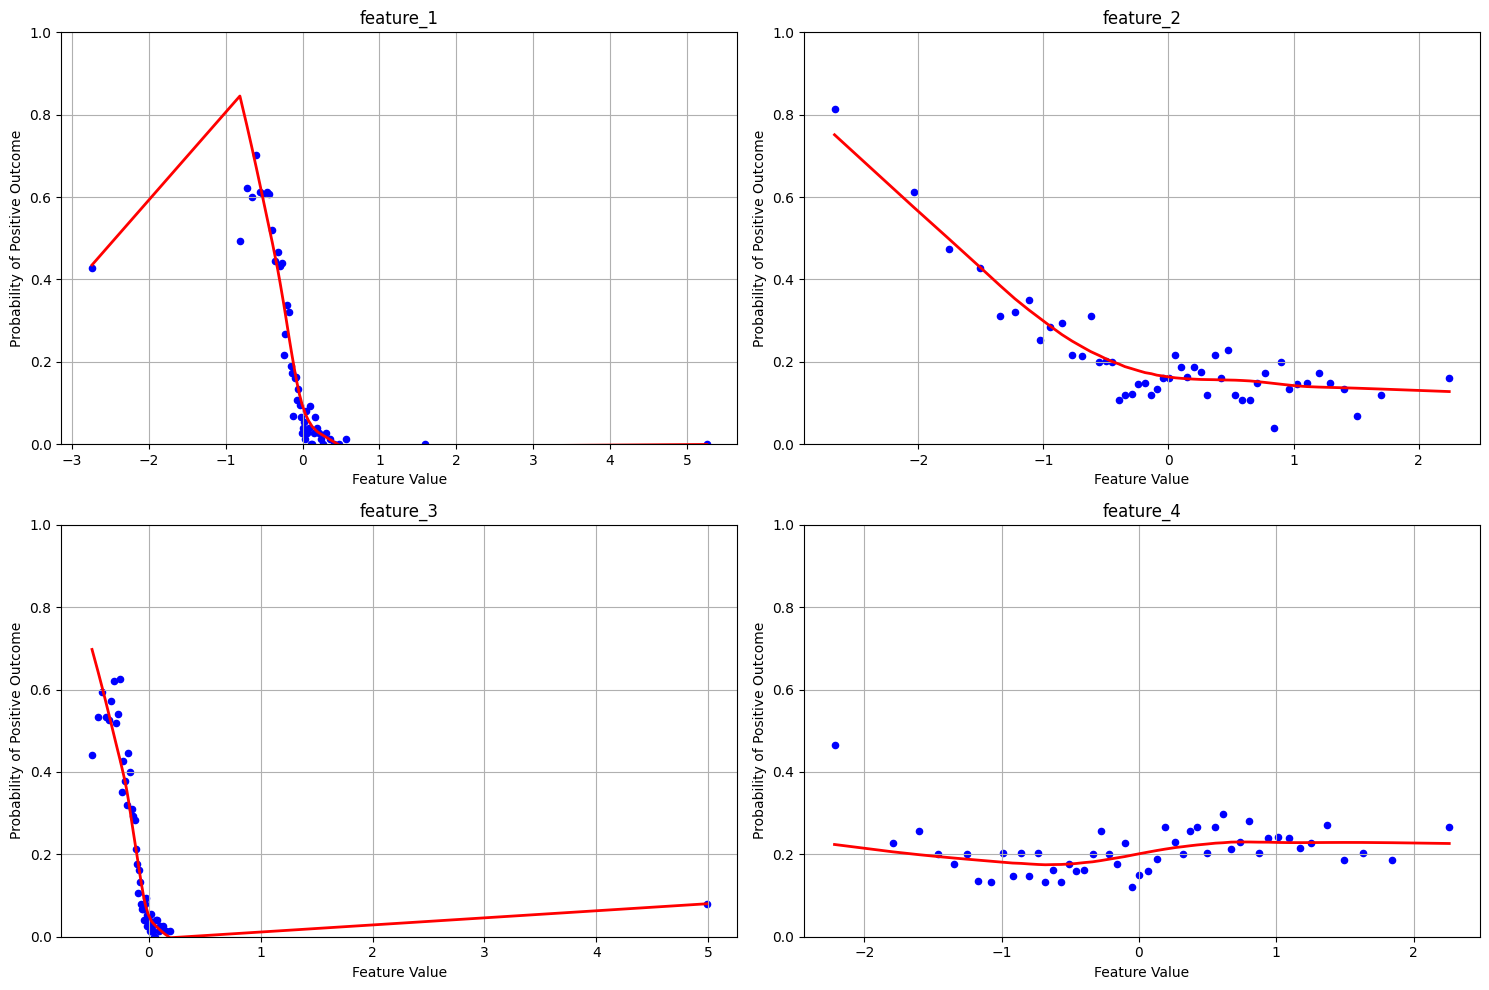

In [255]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(features):
    bins = pd.qcut(train[feature], q=50, duplicates='drop')
    bin_means = train.groupby(bins)[feature].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    axes[idx].scatter(bin_means, bin_probs, color='blue', s=20)
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes[idx])
    
    axes[idx].set_title(feature)
    axes[idx].set_xlabel('Feature Value')
    axes[idx].set_ylabel('Probability of Positive Outcome')
    axes[idx].set_ylim(0, 1)
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

Produce all possible interaction terms.

In [256]:
train['feature_1_x_feature_2'] = train['feature_1'] * train['feature_2']
test['feature_1_x_feature_2'] = test['feature_1'] * test['feature_2']

train['feature_1_x_feature_3'] = train['feature_1'] * train['feature_3']
test['feature_1_x_feature_3'] = test['feature_1'] * test['feature_3']

train['feature_1_x_feature_4'] = train['feature_1'] * train['feature_4']
test['feature_1_x_feature_4'] = test['feature_1'] * test['feature_4']

train['feature_2_x_feature_3'] = train['feature_2'] * train['feature_3']
test['feature_2_x_feature_3'] = test['feature_2'] * test['feature_3']

train['feature_2_x_feature_4'] = train['feature_2'] * train['feature_4']
test['feature_2_x_feature_4'] = test['feature_2'] * test['feature_4']

train['feature_3_x_feature_4'] = train['feature_3'] * train['feature_4']
test['feature_3_x_feature_4'] = test['feature_3'] * test['feature_4']

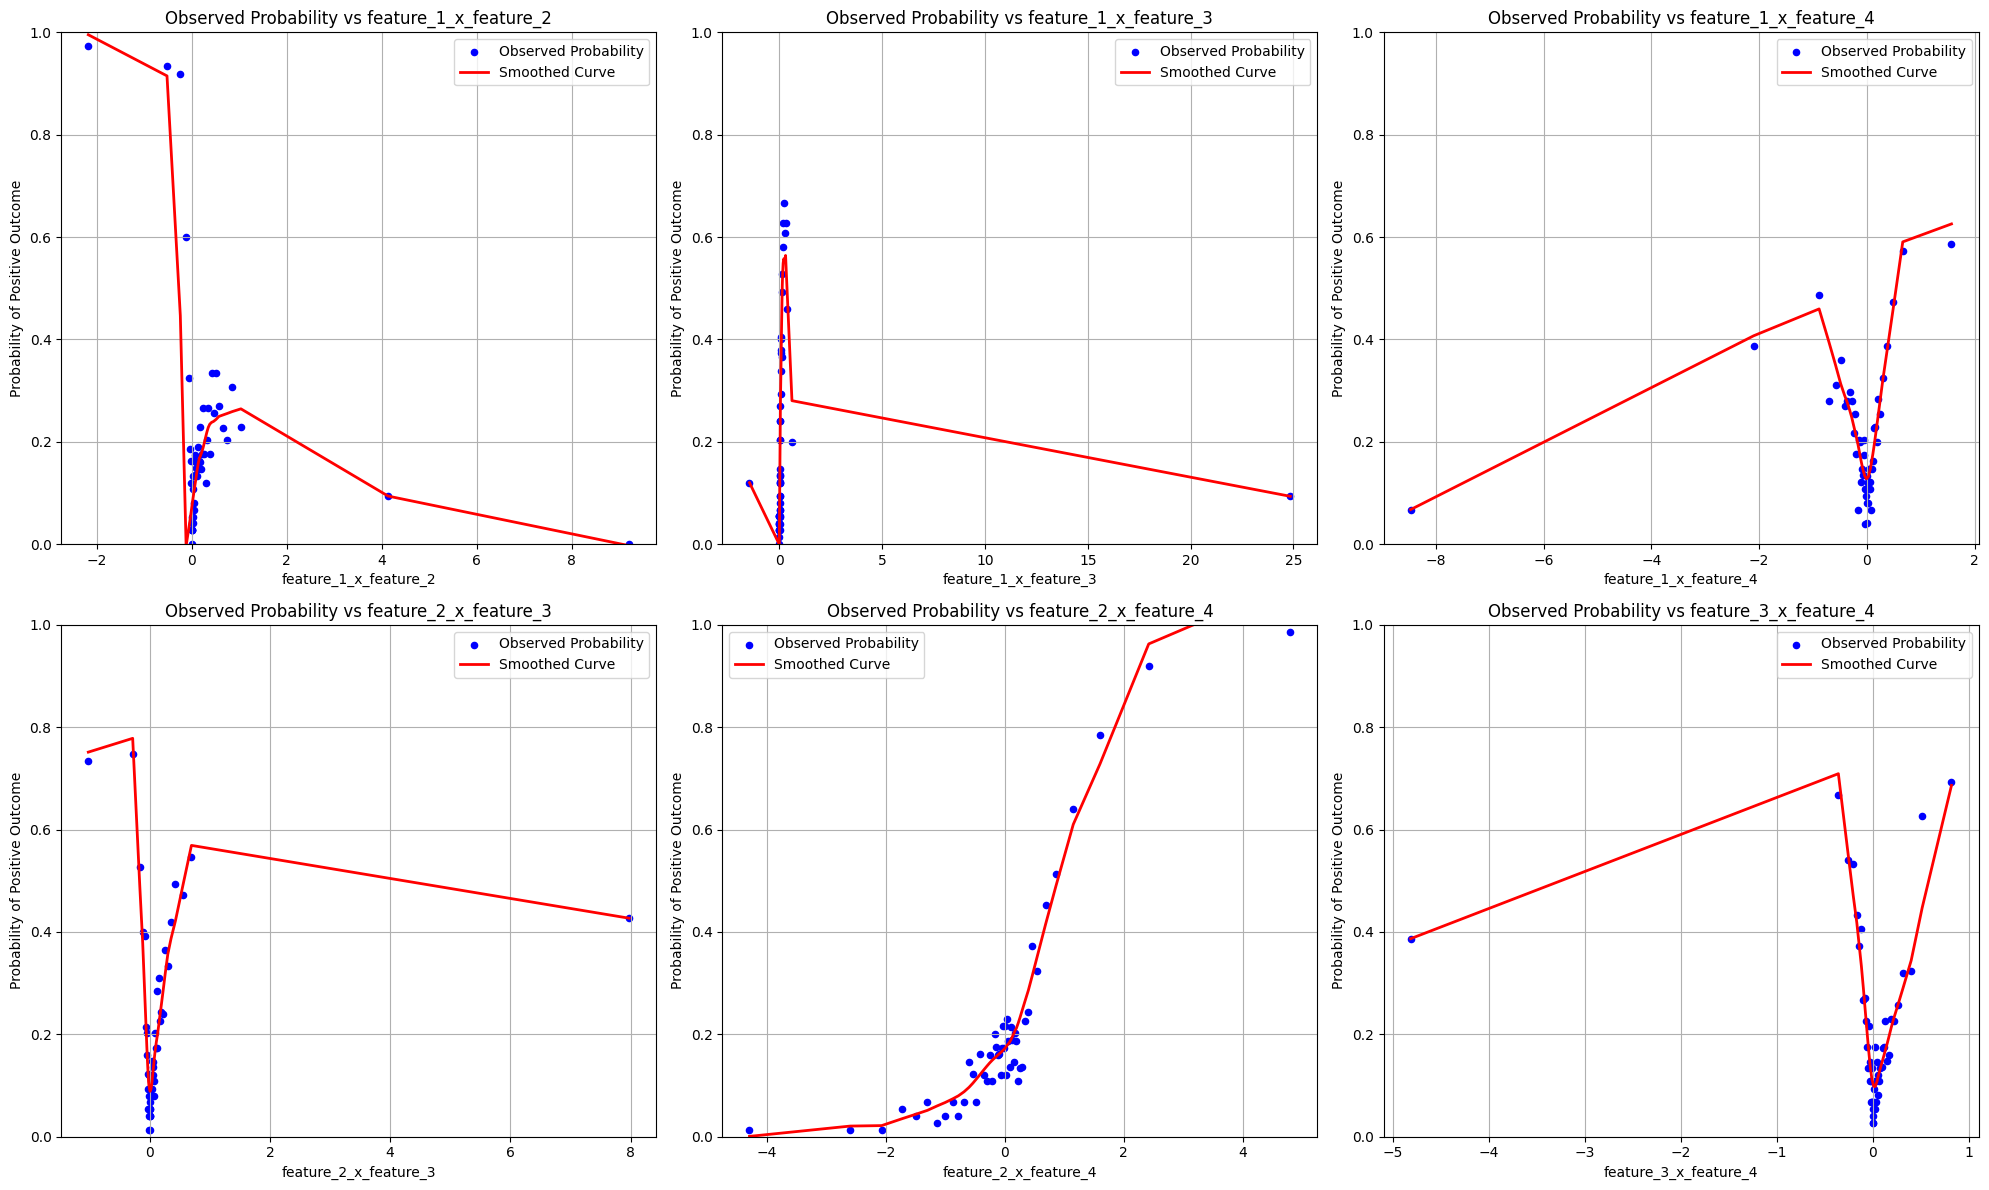

In [257]:
interaction_terms = [
    ('feature_1', 'feature_2'),
    ('feature_1', 'feature_3'), 
    ('feature_1', 'feature_4'),
    ('feature_2', 'feature_3'),
    ('feature_2', 'feature_4'),
    ('feature_3', 'feature_4')
]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, (feat1, feat2) in enumerate(interaction_terms):
    interaction_name = f'{feat1}_x_{feat2}'
    train[interaction_name] = train[feat1] * train[feat2]
    test[interaction_name] = test[feat1] * test[feat2]
    
    bins = pd.qcut(train[interaction_name], q=50, duplicates='drop')
    bin_means = train.groupby(bins)[interaction_name].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    axes[i].scatter(bin_means, bin_probs, color='blue', s=20, label='Observed Probability')
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes[i], label='Smoothed Curve')
    
    axes[i].set_title(f'Observed Probability vs {interaction_name}')
    axes[i].set_xlabel(interaction_name)
    axes[i].set_ylabel('Probability of Positive Outcome')
    axes[i].set_ylim(0, 1)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

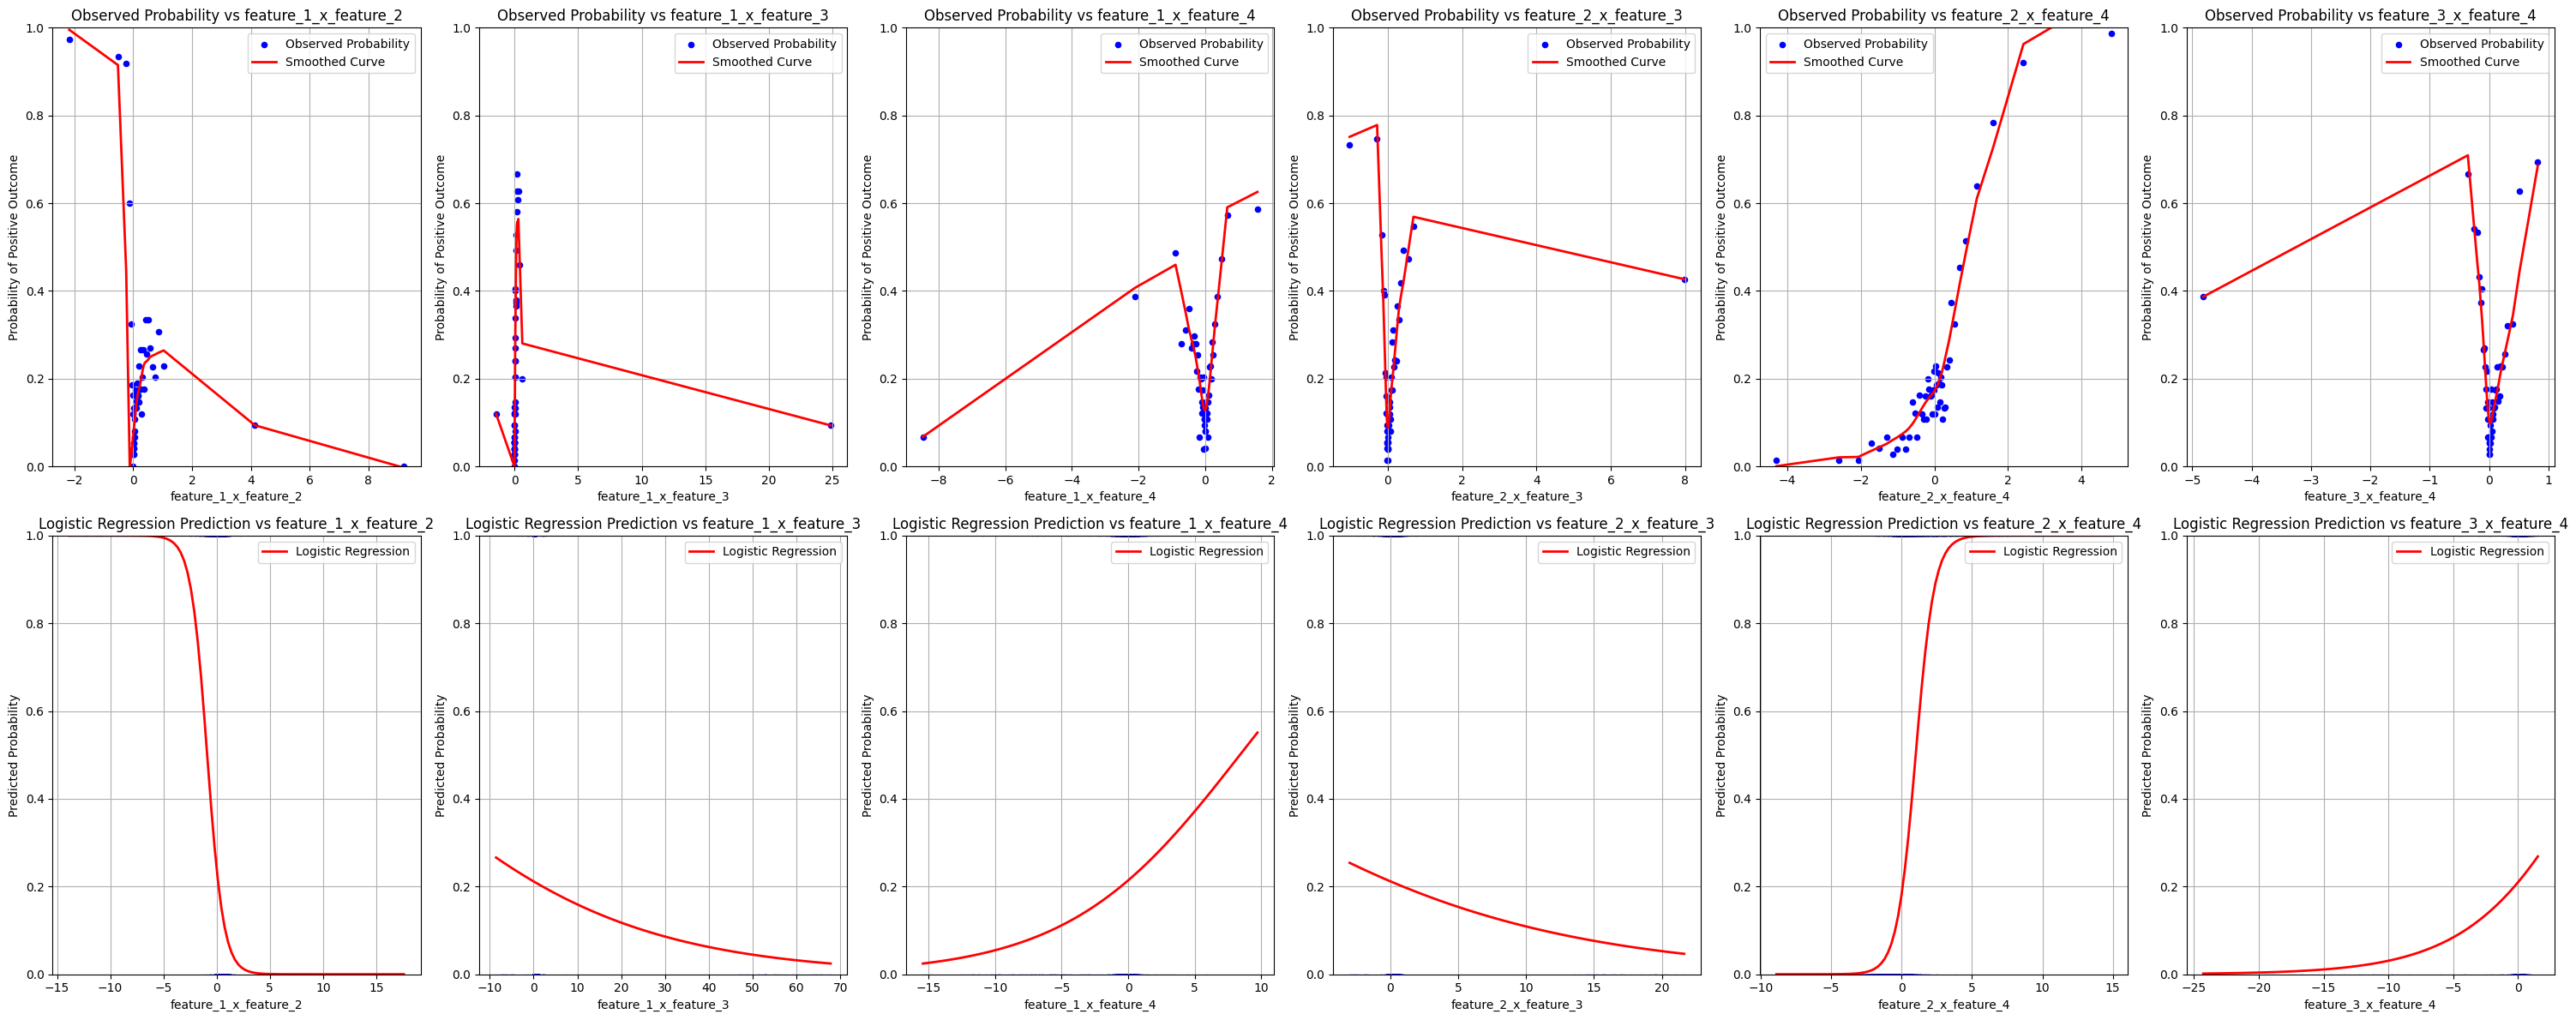

In [258]:
interaction_terms = [
    ('feature_1', 'feature_2'),
    ('feature_1', 'feature_3'), 
    ('feature_1', 'feature_4'),
    ('feature_2', 'feature_3'),
    ('feature_2', 'feature_4'),
    ('feature_3', 'feature_4')
]

from sklearn.linear_model import LogisticRegression

fig, ((ax1, ax2, ax3, ax4, ax5, ax6), 
      (ax7, ax8, ax9, ax10, ax11, ax12)) = plt.subplots(2, 6, figsize=(30, 12))
axes_top = [ax1, ax2, ax3, ax4, ax5, ax6]
axes_bottom = [ax7, ax8, ax9, ax10, ax11, ax12]

for i, (feat1, feat2) in enumerate(interaction_terms):
    interaction_name = f'{feat1}_x_{feat2}'
    train[interaction_name] = train[feat1] * train[feat2]
    test[interaction_name] = test[feat1] * test[feat2]
    
    # Top row - observed probabilities
    bins = pd.qcut(train[interaction_name], q=50, duplicates='drop')
    bin_means = train.groupby(bins)[interaction_name].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    axes_top[i].scatter(bin_means, bin_probs, color='blue', s=20, label='Observed Probability')
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes_top[i], label='Smoothed Curve')
    
    axes_top[i].set_title(f'Observed Probability vs {interaction_name}')
    axes_top[i].set_xlabel(interaction_name)
    axes_top[i].set_ylabel('Probability of Positive Outcome')
    axes_top[i].set_ylim(0, 1)
    axes_top[i].legend()
    axes_top[i].grid(True)
    
    # Bottom row - logistic regression predictions
    X = train[interaction_name].values.reshape(-1, 1)
    y = train['y']
    model = LogisticRegression()
    model.fit(X, y)
    
    X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict_proba(X_plot)[:, 1]
    
    axes_bottom[i].scatter(train[interaction_name], y, color='blue', s=1, alpha=0.1)
    axes_bottom[i].plot(X_plot, y_pred, color='red', lw=2, label='Logistic Regression')
    
    axes_bottom[i].set_title(f'Logistic Regression Prediction vs {interaction_name}')
    axes_bottom[i].set_xlabel(interaction_name)
    axes_bottom[i].set_ylabel('Predicted Probability')
    axes_bottom[i].set_ylim(0, 1)
    axes_bottom[i].legend()
    axes_bottom[i].grid(True)

plt.tight_layout()
plt.show()

what i did to obtain this was first use the interaction terms that were found to have best performance by random trials 
then i found the combination of interaction terms splined which produced the best results by random trial. 

hence this result 



Best Test Recall: 0.9252336448598131
Best Test AUC: 0.9667754244317868

Model variables:
Base features: ['feature_1', 'feature_2', 'feature_3', 'feature_4']

Splined interaction terms:
- feature_1_x_feature_3 (splined)
- feature_3_x_feature_4 (splined)

Regular interaction terms:
- feature_1_x_feature_2
- feature_2_x_feature_3
- feature_2_x_feature_4


CHAT GBT RECOEMNDS AUTO ML

Evaluating all possible combinations:

All combinations sorted by recall (descending):
Recall: 0.925, AUC: 0.967 - Splined terms: ['feature_1_x_feature_3', 'feature_3_x_feature_4']
Recall: 0.921, AUC: 0.966 - Splined terms: ['feature_3_x_feature_4']
Recall: 0.921, AUC: 0.965 - Splined terms: ['feature_2_x_feature_3', 'feature_3_x_feature_4']
Recall: 0.921, AUC: 0.960 - Splined terms: ['feature_2_x_feature_4', 'feature_3_x_feature_4']
Recall: 0.921, AUC: 0.965 - Splined terms: ['feature_1_x_feature_3', 'feature_2_x_feature_3', 'feature_3_x_feature_4']
Recall: 0.921, AUC: 0.961 - Splined terms: ['feature_1_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']
Recall: 0.921, AUC: 0.961 - Splined terms: ['feature_1_x_feature_3', 'feature_2_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']
Recall: 0.916, AUC: 0.964 - Splined terms: ['feature_1_x_feature_3']
Recall: 0.916, AUC: 0.961 - Splined terms: ['feature_2_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feat

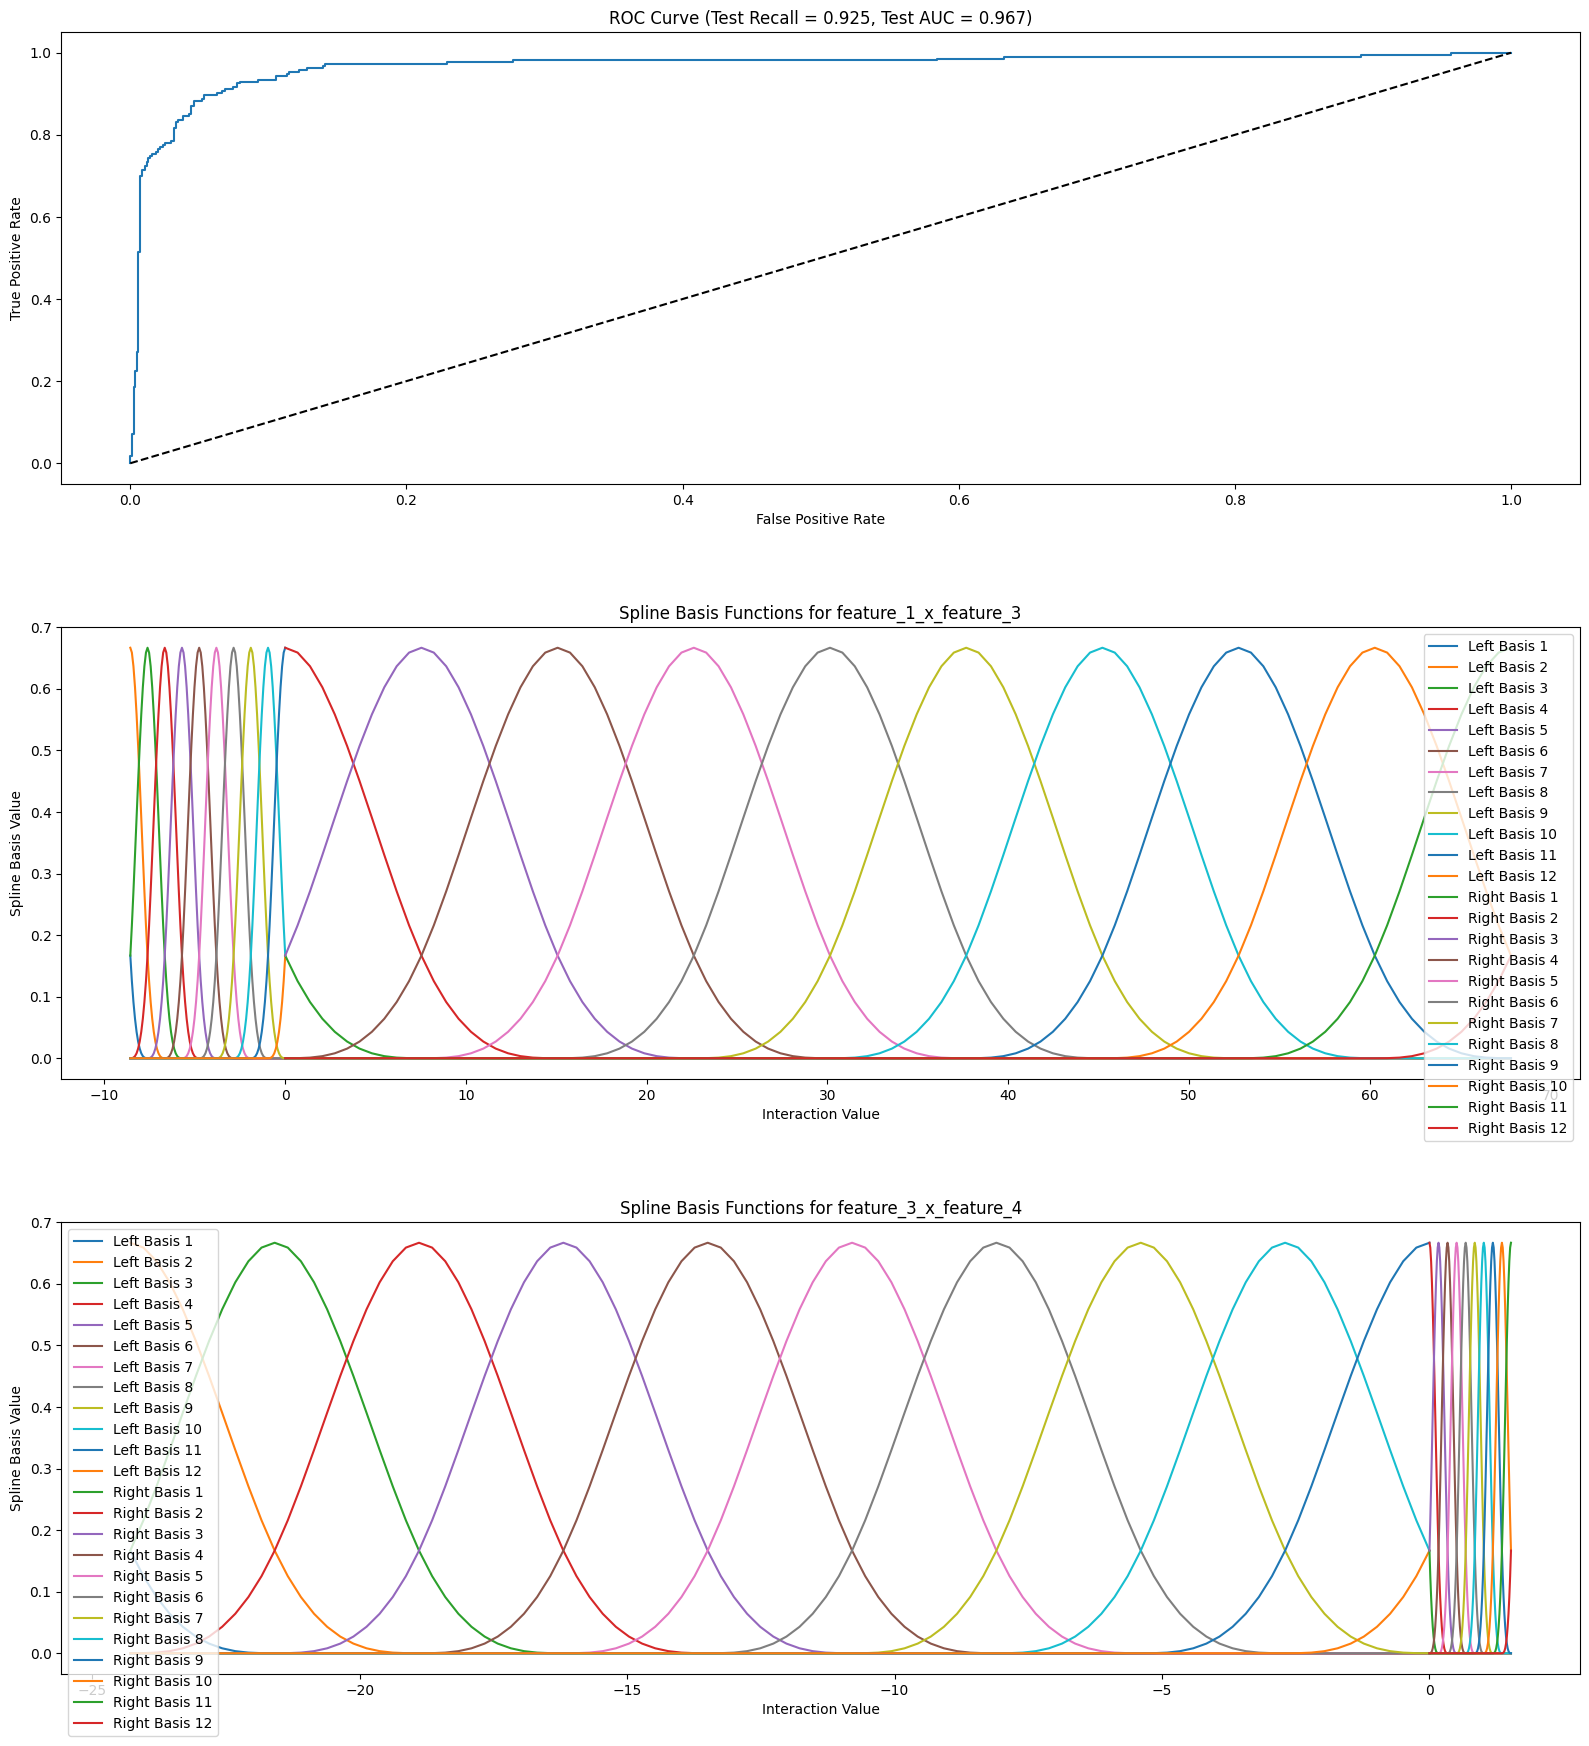


Model variables used for ROC curve:
Base features: ['feature_1', 'feature_2', 'feature_3', 'feature_4']

Splined interaction terms:
- feature_1_x_feature_3 (splined)
- feature_3_x_feature_4 (splined)

Regular interaction terms:
- feature_1_x_feature_2
- feature_2_x_feature_3
- feature_2_x_feature_4

Optimal threshold: 0.314
Final test recall at optimal threshold: 0.925
Final test AUC: 0.967


In [259]:
from sklearn.metrics import roc_curve, recall_score, roc_auc_score
from sklearn.preprocessing import SplineTransformer
import numpy as np
from itertools import combinations

def create_split_splines(data_train, data_test, interaction_term, n_knots=10, degree=3):
    interaction_train = data_train[interaction_term[0]] * data_train[interaction_term[1]]
    interaction_test = data_test[interaction_term[0]] * data_test[interaction_term[1]]
    
    left_mask_train = interaction_train <= 0
    right_mask_train = interaction_train > 0
    left_mask_test = interaction_test <= 0
    right_mask_test = interaction_test > 0
    
    spline_left = SplineTransformer(n_knots=n_knots, degree=degree)
    spline_right = SplineTransformer(n_knots=n_knots, degree=degree)
    
    left_spline_train = spline_left.fit_transform(interaction_train[left_mask_train].values.reshape(-1, 1))
    right_spline_train = spline_right.fit_transform(interaction_train[right_mask_train].values.reshape(-1, 1))
    
    left_spline_test = spline_left.transform(interaction_test[left_mask_test].values.reshape(-1, 1))
    right_spline_test = spline_right.transform(interaction_test[right_mask_test].values.reshape(-1, 1))
    
    X_train_spline = np.zeros((len(data_train), left_spline_train.shape[1] + right_spline_train.shape[1]))
    X_test_spline = np.zeros((len(data_test), left_spline_train.shape[1] + right_spline_train.shape[1]))
    
    X_train_spline[left_mask_train, :left_spline_train.shape[1]] = left_spline_train
    X_train_spline[right_mask_train, left_spline_train.shape[1]:] = right_spline_train
    
    X_test_spline[left_mask_test, :left_spline_test.shape[1]] = left_spline_test
    X_test_spline[right_mask_test, left_spline_test.shape[1]:] = right_spline_test
    
    return X_train_spline, X_test_spline, spline_left, spline_right

def get_optimal_threshold_recall(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    fnr = 1 - tpr
    optimal_idx = np.argmin(np.abs(fpr - fnr))
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    return recall_score(y_true, y_pred)

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
interaction_terms = [
    ['feature_1', 'feature_2'],
    ['feature_1', 'feature_3'], 
    ['feature_2', 'feature_3'],
    ['feature_2', 'feature_4'],
    ['feature_3', 'feature_4']
]

X_train = train[features]
X_test = test[features]
y_train = train['y']
y_test = test['y']

best_recall = 0
best_auc = 0
best_combination = None
all_results = []
spline_transformers = {}

print("Evaluating all possible combinations:")
for r in range(len(interaction_terms) + 1):
    for spline_terms in combinations(range(len(interaction_terms)), r):
        X_train_splines = []
        X_test_splines = []
        
        spline_desc = "None" if len(spline_terms) == 0 else [f"{interaction_terms[i][0]}_x_{interaction_terms[i][1]}" for i in spline_terms]
        
        for i, interaction_term in enumerate(interaction_terms):
            if i in spline_terms:
                X_train_spline, X_test_spline, spline_left, spline_right = create_split_splines(train, test, interaction_term)
                X_train_splines.append(X_train_spline)
                X_test_splines.append(X_test_spline)
                spline_transformers[i] = (spline_left, spline_right)
            elif i not in spline_terms:
                interaction_name = f'{interaction_term[0]}_x_{interaction_term[1]}'
                X_train_splines.append(train[interaction_name].values.reshape(-1, 1))
                X_test_splines.append(test[interaction_name].values.reshape(-1, 1))

        X_train_final = np.hstack([X_train] + X_train_splines)
        X_test_final = np.hstack([X_test] + X_test_splines)

        model = LogisticRegression(fit_intercept=True)
        model.fit(X_train_final, y_train)
        test_pred_proba = model.predict_proba(X_test_final)[:, 1]
        recall = get_optimal_threshold_recall(y_test, test_pred_proba)
        auc = roc_auc_score(y_test, test_pred_proba)
        all_results.append((recall, auc, spline_desc))
        
        if recall > best_recall:
            best_recall = recall
            best_auc = auc
            best_combination = spline_terms

print("\nAll combinations sorted by recall (descending):")
all_results = sorted(all_results, key=lambda x: x[0], reverse=True)
for recall, auc, spline_desc in all_results:
    print(f"Recall: {recall:.3f}, AUC: {auc:.3f} - Splined terms: {spline_desc}")

print(f"\nBest Test Recall: {best_recall}")
print(f"Best Test AUC: {best_auc}")
print("\nModel variables:")
print("Base features:", features)
print("\nSplined interaction terms:")
for i in best_combination:
    print(f"- {interaction_terms[i][0]}_x_{interaction_terms[i][1]} (splined)")
print("\nRegular interaction terms:")
for i in range(len(interaction_terms)):
    if i not in best_combination:
        print(f"- {interaction_terms[i][0]}_x_{interaction_terms[i][1]}")

X_train_splines = []
X_test_splines = []

for i, interaction_term in enumerate(interaction_terms):
    if i in best_combination:
        X_train_spline, X_test_spline, spline_left, spline_right = create_split_splines(train, test, interaction_term)
        X_train_splines.append(X_train_spline)
        X_test_splines.append(X_test_spline)
        spline_transformers[i] = (spline_left, spline_right)
    elif i not in best_combination:
        interaction_name = f'{interaction_term[0]}_x_{interaction_term[1]}'
        X_train_splines.append(train[interaction_name].values.reshape(-1, 1))
        X_test_splines.append(test[interaction_name].values.reshape(-1, 1))

X_train_final = np.hstack([X_train] + X_train_splines)
X_test_final = np.hstack([X_test] + X_test_splines)

model = LogisticRegression(fit_intercept=True)
model.fit(X_train_final, y_train)

test_pred_proba = model.predict_proba(X_test_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
fnr = 1 - tpr
optimal_idx = np.argmin(np.abs(fpr - fnr))
optimal_threshold = thresholds[optimal_idx]

y_pred = (test_pred_proba >= optimal_threshold).astype(int)
final_recall = recall_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, test_pred_proba)

fig, axes = plt.subplots(len(best_combination) + 1, 1, figsize=(16, 6 * (len(best_combination) + 1)))

axes[0].plot(fpr, tpr)
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title(f'ROC Curve (Test Recall = {final_recall:.3f}, Test AUC = {final_auc:.3f})')

for idx, i in enumerate(best_combination, 1):
    interaction_name = f'{interaction_terms[i][0]}_x_{interaction_terms[i][1]}'
    interaction_values = train[interaction_terms[i][0]] * train[interaction_terms[i][1]]
    
    X_left = np.linspace(interaction_values[interaction_values <= 0].min(), 0, 100).reshape(-1, 1)
    X_right = np.linspace(0, interaction_values[interaction_values > 0].max(), 100).reshape(-1, 1)
    
    spline_left, spline_right = spline_transformers[i]
    y_left = spline_left.transform(X_left)
    y_right = spline_right.transform(X_right)
    
    for j in range(y_left.shape[1]):
        axes[idx].plot(X_left, y_left[:, j], label=f'Left Basis {j+1}')
    for j in range(y_right.shape[1]):
        axes[idx].plot(X_right, y_right[:, j], label=f'Right Basis {j+1}')
    
    axes[idx].set_xlabel('Interaction Value')
    axes[idx].set_ylabel('Spline Basis Value')
    axes[idx].set_title(f'Spline Basis Functions for {interaction_name}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

print("\nModel variables used for ROC curve:")
print("Base features:", features)
print("\nSplined interaction terms:")
for i in best_combination:
    print(f"- {interaction_terms[i][0]}_x_{interaction_terms[i][1]} (splined)")
print("\nRegular interaction terms:")
for i in range(len(interaction_terms)):
    if i not in best_combination:
        print(f"- {interaction_terms[i][0]}_x_{interaction_terms[i][1]}")

print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"Final test recall at optimal threshold: {final_recall:.3f}")
print(f"Final test AUC: {final_auc:.3f}")

we could use the ExhaustiveFeatureSelector from mlxtend and evaluate all base features + all interaction terms + all splined interactions that way every possible combination is tested (yeah that just produced an infiinite loop computation)

Optimization terminated successfully.
         Current function value: 0.393480
         Iterations 8


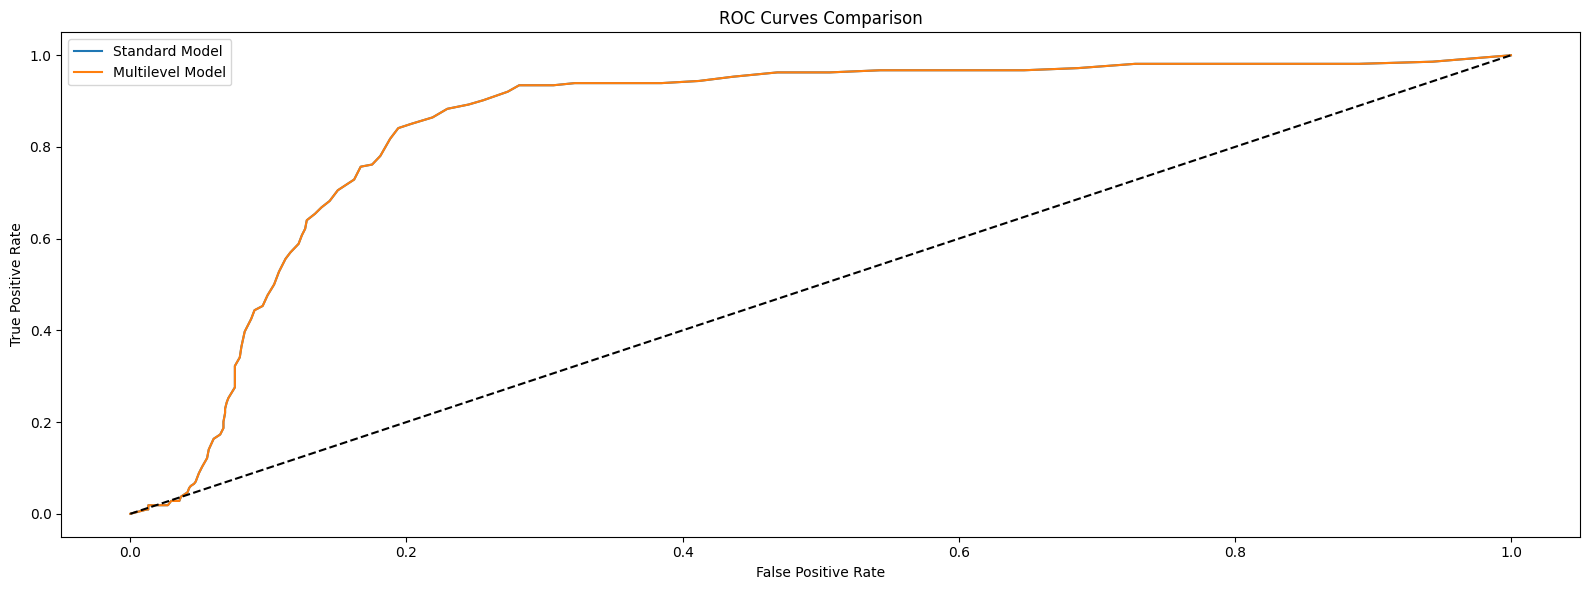


Model variables used for ROC curves:
Base features: ['feature_1', 'feature_2', 'feature_3', 'feature_4']

Standard Model:
Optimal threshold: 0.263
Final test recall at optimal threshold: 0.818
Final test AUC: -0.853

Multilevel Model:
Optimal threshold: 0.263
Final test recall at optimal threshold: 0.818
Final test AUC: -0.853


In [260]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']

# Create formula strings for both models
formula_standard = "y ~ " + " + ".join(features)
formula_multilevel = formula_standard

# Fit standard logistic regression
model_standard = sm.Logit(train['y'], sm.add_constant(train[features])).fit()
test_pred_proba_standard = model_standard.predict(sm.add_constant(test[features]))

# Fit GEE model with logit link and binomial family
model_multilevel = smf.gee(
    formula=formula_multilevel,
    groups="id", 
    data=train,
    family=sm.families.Binomial()
)
results_multilevel = model_multilevel.fit()
test_pred_proba_multilevel = results_multilevel.predict(test)

thresholds = np.linspace(0, 1, 100)
fpr_standard = np.zeros_like(thresholds)
tpr_standard = np.zeros_like(thresholds)
fpr_multilevel = np.zeros_like(thresholds)
tpr_multilevel = np.zeros_like(thresholds)

for i, threshold in enumerate(thresholds):
    # Standard model metrics
    y_pred_standard = (test_pred_proba_standard >= threshold).astype(int)
    tn = np.sum((y_test == 0) & (y_pred_standard == 0))
    fp = np.sum((y_test == 0) & (y_pred_standard == 1))
    fn = np.sum((y_test == 1) & (y_pred_standard == 0))
    tp = np.sum((y_test == 1) & (y_pred_standard == 1))
    fpr_standard[i] = fp / (fp + tn)
    tpr_standard[i] = tp / (tp + fn)
    
    # Multilevel model metrics
    y_pred_multilevel = (test_pred_proba_multilevel >= threshold).astype(int)
    tn = np.sum((y_test == 0) & (y_pred_multilevel == 0))
    fp = np.sum((y_test == 0) & (y_pred_multilevel == 1))
    fn = np.sum((y_test == 1) & (y_pred_multilevel == 0))
    tp = np.sum((y_test == 1) & (y_pred_multilevel == 1))
    fpr_multilevel[i] = fp / (fp + tn)
    tpr_multilevel[i] = tp / (tp + fn)

fnr_standard = 1 - tpr_standard
optimal_idx_standard = np.argmin(np.abs(fpr_standard - fnr_standard))
optimal_threshold_standard = thresholds[optimal_idx_standard]

fnr_multilevel = 1 - tpr_multilevel
optimal_idx_multilevel = np.argmin(np.abs(fpr_multilevel - fnr_multilevel))
optimal_threshold_multilevel = thresholds[optimal_idx_multilevel]

y_pred_standard = (test_pred_proba_standard >= optimal_threshold_standard).astype(int)
final_recall_standard = np.sum((y_test == 1) & (y_pred_standard == 1)) / np.sum(y_test == 1)
final_auc_standard = np.trapz(tpr_standard, fpr_standard)

y_pred_multilevel = (test_pred_proba_multilevel >= optimal_threshold_multilevel).astype(int)
final_recall_multilevel = np.sum((y_test == 1) & (y_pred_multilevel == 1)) / np.sum(y_test == 1)
final_auc_multilevel = np.trapz(tpr_multilevel, fpr_multilevel)

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(fpr_standard, tpr_standard, label='Standard Model')
ax.plot(fpr_multilevel, tpr_multilevel, label='Multilevel Model')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison')
ax.legend()

plt.tight_layout()
plt.show()

print("\nModel variables used for ROC curves:")
print("Base features:", features)

print("\nStandard Model:")
print(f"Optimal threshold: {optimal_threshold_standard:.3f}")
print(f"Final test recall at optimal threshold: {final_recall_standard:.3f}")
print(f"Final test AUC: {final_auc_standard:.3f}")

print("\nMultilevel Model:")
print(f"Optimal threshold: {optimal_threshold_multilevel:.3f}")
print(f"Final test recall at optimal threshold: {final_recall_multilevel:.3f}")
print(f"Final test AUC: {final_auc_multilevel:.3f}")

Model variables:
Base features: ['feature_1', 'feature_2', 'feature_3', 'feature_4']

Splined interaction terms:
- feature_1_x_feature_3 (splined)
- feature_3_x_feature_4 (splined)

Regular interaction terms:
- feature_1_x_feature_2
- feature_2_x_feature_3
- feature_2_x_feature_4

In [261]:
print(train.head())

   feature_1  feature_2  feature_3  feature_4     id  date  y  \
0   0.053493   0.057374  -0.073933  -0.420557  50501  2000  0   
1  -0.315388   0.029476  -0.140006   0.997907  50501  2001  1   
2  -0.225211  -1.153009  -0.069998   1.362336  50501  2002  0   
3  -0.209159  -0.067340  -0.153642   0.145434  50501  2003  0   
4  -0.174308  -1.690908  -0.005939   1.902415  50501  2004  0   

   feature_1_x_feature_2  feature_1_x_feature_3  feature_1_x_feature_4  \
0               0.003069              -0.003955              -0.022497   
1              -0.009296               0.044156              -0.314728   
2               0.259670               0.015764              -0.306812   
3               0.014085               0.032135              -0.030419   
4               0.294739               0.001035              -0.331607   

   feature_2_x_feature_3  feature_2_x_feature_4  feature_3_x_feature_4  
0              -0.004242              -0.024129               0.031093  
1              -0.

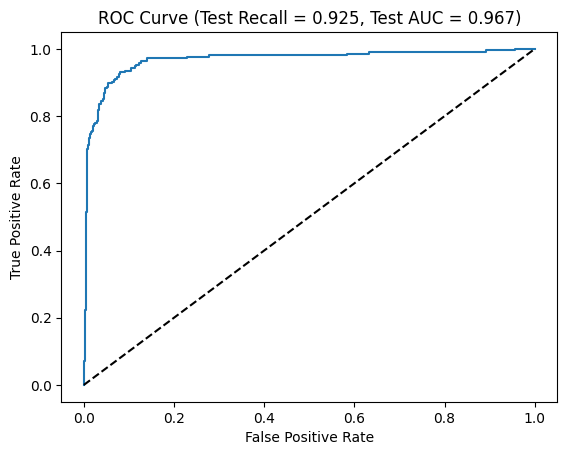

Optimal threshold: 0.314
Final test recall at optimal threshold: 0.925
Final test AUC: 0.967


In [262]:
from sklearn.metrics import roc_curve, recall_score, roc_auc_score
from sklearn.preprocessing import SplineTransformer
import numpy as np

def create_split_splines(data_train, data_test, interaction_term, n_knots=10, degree=3):
    interaction_train = data_train[interaction_term[0]] * data_train[interaction_term[1]]
    interaction_test = data_test[interaction_term[0]] * data_test[interaction_term[1]]
    
    spline_left = SplineTransformer(n_knots=n_knots, degree=degree)
    spline_right = SplineTransformer(n_knots=n_knots, degree=degree)
    
    left_mask_train = interaction_train <= 0
    right_mask_train = ~left_mask_train
    left_mask_test = interaction_test <= 0 
    right_mask_test = ~left_mask_test
    
    X_train_spline = np.zeros((len(data_train), 2 * n_knots + 2 * degree - 2))
    X_test_spline = np.zeros((len(data_test), 2 * n_knots + 2 * degree - 2))
    
    n_features = n_knots + degree - 1
    X_train_spline[left_mask_train, :n_features] = spline_left.fit_transform(interaction_train[left_mask_train].values.reshape(-1, 1))
    X_train_spline[right_mask_train, n_features:] = spline_right.fit_transform(interaction_train[right_mask_train].values.reshape(-1, 1))
    X_test_spline[left_mask_test, :n_features] = spline_left.transform(interaction_test[left_mask_test].values.reshape(-1, 1))
    X_test_spline[right_mask_test, n_features:] = spline_right.transform(interaction_test[right_mask_test].values.reshape(-1, 1))
    
    return X_train_spline, X_test_spline, spline_left, spline_right

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
splined_interactions = [['feature_1', 'feature_3'], ['feature_3', 'feature_4']]
regular_interactions = [['feature_1', 'feature_2'], ['feature_2', 'feature_3'], ['feature_2', 'feature_4']]

X_train = train[features]
X_test = test[features]
y_train = train['y']
y_test = test['y']

X_train_splines = [X_train]
X_test_splines = [X_test]
spline_transformers = {}

for i, interaction in enumerate(splined_interactions):
    X_train_spline, X_test_spline, spline_left, spline_right = create_split_splines(train, test, interaction)
    X_train_splines.append(X_train_spline)
    X_test_splines.append(X_test_spline)
    spline_transformers[i] = (spline_left, spline_right)

for interaction in regular_interactions:
    X_train_splines.append((train[interaction[0]] * train[interaction[1]]).values.reshape(-1, 1))
    X_test_splines.append((test[interaction[0]] * test[interaction[1]]).values.reshape(-1, 1))

X_train_final = np.hstack(X_train_splines)
X_test_final = np.hstack(X_test_splines)

model = LogisticRegression(fit_intercept=True)
model.fit(X_train_final, y_train)
test_pred_proba = model.predict_proba(X_test_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
optimal_threshold = thresholds[np.argmin(np.abs(fpr - (1-tpr)))]
y_pred = (test_pred_proba >= optimal_threshold).astype(int)

final_recall = recall_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, test_pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Test Recall = {final_recall:.3f}, Test AUC = {final_auc:.3f})')
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Final test recall at optimal threshold: {final_recall:.3f}")
print(f"Final test AUC: {final_auc:.3f}")

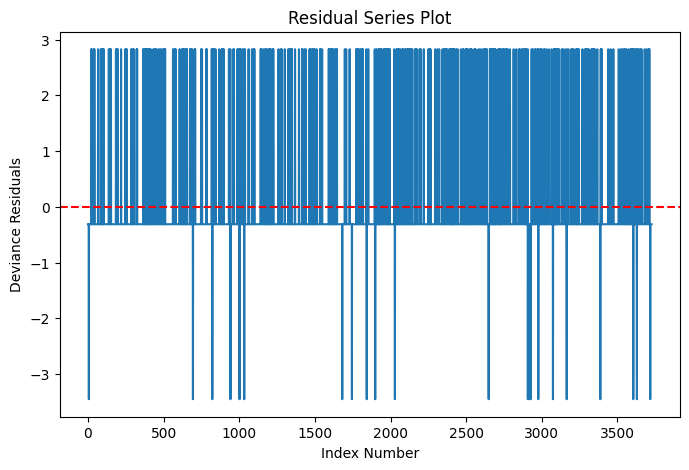

In [263]:
from statsmodels.api import GLM, families
from scipy import stats

logit_results = GLM(y_train, X_train_final, family=families.Binomial()).fit()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
                     xlabel="Index Number", 
                     ylabel="Deviance Residuals")

ax.plot(range(len(X_train_final)), 
        stats.zscore(logit_results.resid_deviance))

plt.axhline(y=0, ls="--", color='red')
plt.show()

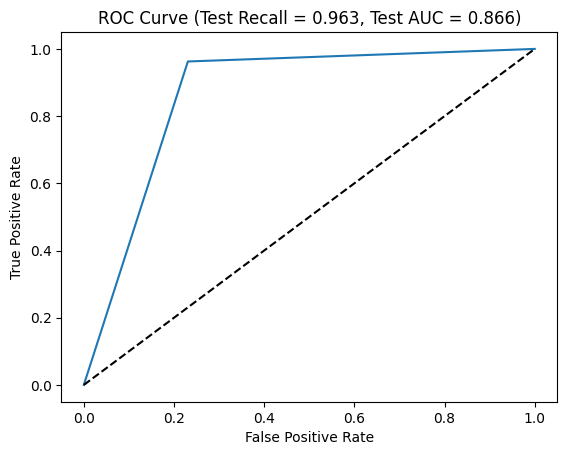

Optimal threshold: 1.000
Final test recall at optimal threshold: 0.963
Final test AUC: 0.866


In [264]:
from statsmodels.api import GLM, families
import statsmodels.api as sm

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
interactions = [['feature_1', 'feature_2'], ['feature_1', 'feature_3'], 
               ['feature_2', 'feature_3'], ['feature_2', 'feature_4'],
               ['feature_3', 'feature_4']]

X_train = train[features].values
X_test = test[features].values
y_train = train['y'].values
y_test = test['y'].values

X_train_splines = [X_train]
X_test_splines = [X_test]

for interaction in interactions:
    X_train_splines.append((train[interaction[0]] * train[interaction[1]]).values.reshape(-1, 1))
    X_test_splines.append((test[interaction[0]] * test[interaction[1]]).values.reshape(-1, 1))

X_train_final = np.hstack(X_train_splines)
X_test_final = np.hstack(X_test_splines)

model = GLM(y_train, sm.add_constant(X_train_final), family=families.Binomial())
results = model.fit()
test_pred_proba = results.predict(sm.add_constant(X_test_final))

fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
optimal_threshold = thresholds[np.argmin(np.abs(fpr - (1-tpr)))]
y_pred = (test_pred_proba >= optimal_threshold).astype(int)

final_recall = recall_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, test_pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Test Recall = {final_recall:.3f}, Test AUC = {final_auc:.3f})')
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Final test recall at optimal threshold: {final_recall:.3f}")
print(f"Final test AUC: {final_auc:.3f}")